In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-images-idx3-ubyte


In [2]:
# Load data
train_data = pd.read_csv('../input/fashionmnist/fashion-mnist_train.csv')
test_data = pd.read_csv('../input/fashionmnist/fashion-mnist_test.csv')

In [3]:
# Separating labels and samples
x_train, y_train = train_data.iloc[:, 1:], train_data.iloc[:, :1]
x_test, y_test = test_data.iloc[:, 1:], test_data.iloc[:, :1]
print(f'Shape of train data: images{x_train.shape}, labels{y_train.shape}')
print(f'Shape of test data: images{x_test.shape}, labels{y_test.shape}')

Shape of train data: images(60000, 784), labels(60000, 1)
Shape of test data: images(10000, 784), labels(10000, 1)


In [4]:
# Normalization
x_train, x_test = x_train/255, x_test/255

In [5]:
x_train.describe()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,0.000004,0.000024,0.000139,0.000400,0.000972,0.001614,0.003160,0.008621,0.022282,0.056819,...,0.135786,0.091375,0.065052,0.070076,0.089470,0.070241,0.033414,0.010797,0.003355,0.000275
std,0.000371,0.001063,0.004793,0.009619,0.016890,0.022887,0.032216,0.055268,0.093410,0.150332,...,0.225668,0.191586,0.164626,0.172416,0.203257,0.177056,0.116137,0.068226,0.036694,0.008337
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.227451,0.035294,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.062745,0.141176,0.886275,0.643137,0.890196,0.901961,0.878431,1.000000,0.996078,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.666667


In [6]:
# Convertation to tensor
train_x_tensor = torch.Tensor(x_train.values)
train_y_tensor = torch.Tensor(y_train.values).type(torch.LongTensor)
test_x_tensor = torch.Tensor(x_test.values)
test_y_tensor = torch.Tensor(y_test.values).type(torch.LongTensor)

In [7]:
# Make tensor datasets
train_dataset = TensorDataset(train_x_tensor, train_y_tensor)
test_dataset = TensorDataset(test_x_tensor, test_y_tensor)

In [8]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X : ", X.shape, X.dtype)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X :  torch.Size([64, 784]) torch.float32
Shape of y:  torch.Size([64, 1]) torch.int64


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


In [10]:
# Creating Models
class Net(nn.Module):
    
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        x = torch.log_softmax(x, dim=1)
        return x
    
    def loss(self, X, y, **kwargs):
        self._loss = F.nll_loss(X, y, **kwargs)
        return self._loss

In [11]:
model = Net().to(device)
model

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [12]:
train_logs = []
test_logs = []

In [13]:
def train(dataloader, model):
    model.train()
    train_size = len(dataloader.dataset)
    train_correct = 0.
    for batch, (X, y) in enumerate(dataloader):
        y = y.view(-1)
        X, y = X.to(device), y.to(device)
        #train
        pred = model(X)
        train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        loss = model.loss(pred, y)
        #Backpropagation
        model.optim.zero_grad()
        loss.backward()
        model.optim.step()
            
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{train_size:>5d}]")
            
    train_correct /= train_size
    train_logs.append(train_correct)

In [14]:
def test(dataloader, model):
    model.eval()
    test_size = len(dataloader.dataset)
    test_loss, correct = 0., 0.
    with torch.no_grad():
        for X, y in dataloader:
            y = y.view(-1)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += model.loss(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= test_size
    correct /= test_size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    test_logs.append(correct)

In [15]:
epochs = 100

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model)
    test(test_dataloader, model)
print("Done!")

Epoch 1
-------------------------------
loss: 2.286895  [    0/60000]
loss: 1.492557  [ 6400/60000]
loss: 1.059658  [12800/60000]
loss: 0.847986  [19200/60000]
loss: 0.779580  [25600/60000]
loss: 0.747846  [32000/60000]
loss: 0.625693  [38400/60000]
loss: 0.466233  [44800/60000]
loss: 0.450634  [51200/60000]
loss: 0.545554  [57600/60000]
Test Error: 
 Accuracy: 81.0%, Avg loss: 0.008788 

Epoch 2
-------------------------------
loss: 0.623232  [    0/60000]
loss: 0.541669  [ 6400/60000]
loss: 0.623834  [12800/60000]
loss: 0.542077  [19200/60000]
loss: 0.434814  [25600/60000]
loss: 0.454999  [32000/60000]
loss: 0.458384  [38400/60000]
loss: 0.318394  [44800/60000]
loss: 0.340657  [51200/60000]
loss: 0.415437  [57600/60000]
Test Error: 
 Accuracy: 83.9%, Avg loss: 0.007175 

Epoch 3
-------------------------------
loss: 0.518051  [    0/60000]
loss: 0.471006  [ 6400/60000]
loss: 0.581626  [12800/60000]
loss: 0.471476  [19200/60000]
loss: 0.362198  [25600/60000]
loss: 0.391661  [32000/600

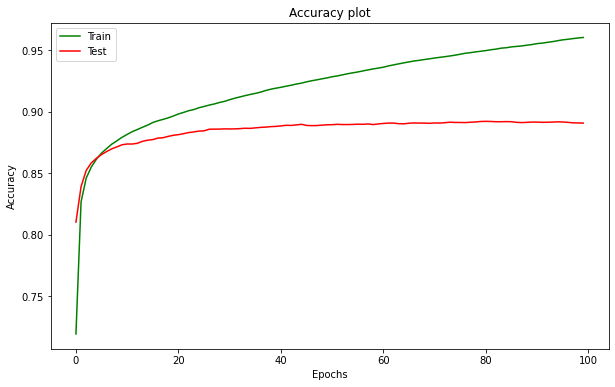

In [16]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
x_axes = list(range(epochs))

ax.set(xlabel="Epochs",
       ylabel="Accuracy",
       title="Accuracy plot")

ax.plot(x_axes, train_logs, color="green", label="Train")
ax.plot(x_axes, test_logs, color="red", label="Test")

plt.legend()
plt.show()